In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Deterministic SIR

In the following, we provide a function that integrates numerically the system of differential equations defining the SIR model:

In [3]:
def SIR_deterministic(beta : float,
                      mu : float, 
                      N : int, 
                      dt : float = 1.0, 
                      I0_frac : float = 0.01, 
                      T : int  = 100):
    """
    This function numerically integrates the system of ODEs defining the SIR model
    Parameters
    ----------
    - beta (float): transmission rate
    - mu (float): recovery rate
    - N (int): population size 
    - dt (float, optional): integration step. Default is 1.0.
    - I0_frac (float, optional): initial fraction of infected. Default is 0.01 (1%).
    - T (int, optional): simulation length in steps. Default is 100. 
    
    Returns
    -------
    - evolution of S, I, R compartments
    """
    I0 = int(N * I0_frac)
    S, I, R, t = [N - I0], [I0], [0], [0]
    for i in range(T):
        new_infected = (S[-1] * beta * I[-1] / N) * dt
        new_recovered = (I[-1] * mu) * dt
        S.append(S[-1] - new_infected)
        I.append(I[-1] + new_infected - new_recovered)
        R.append(R[-1] + new_recovered)
        t.append(t[-1] + dt)
    return np.array(S), np.array(I), np.array(R), np.array(t)

Text(0, 0.5, '$i(t)$')

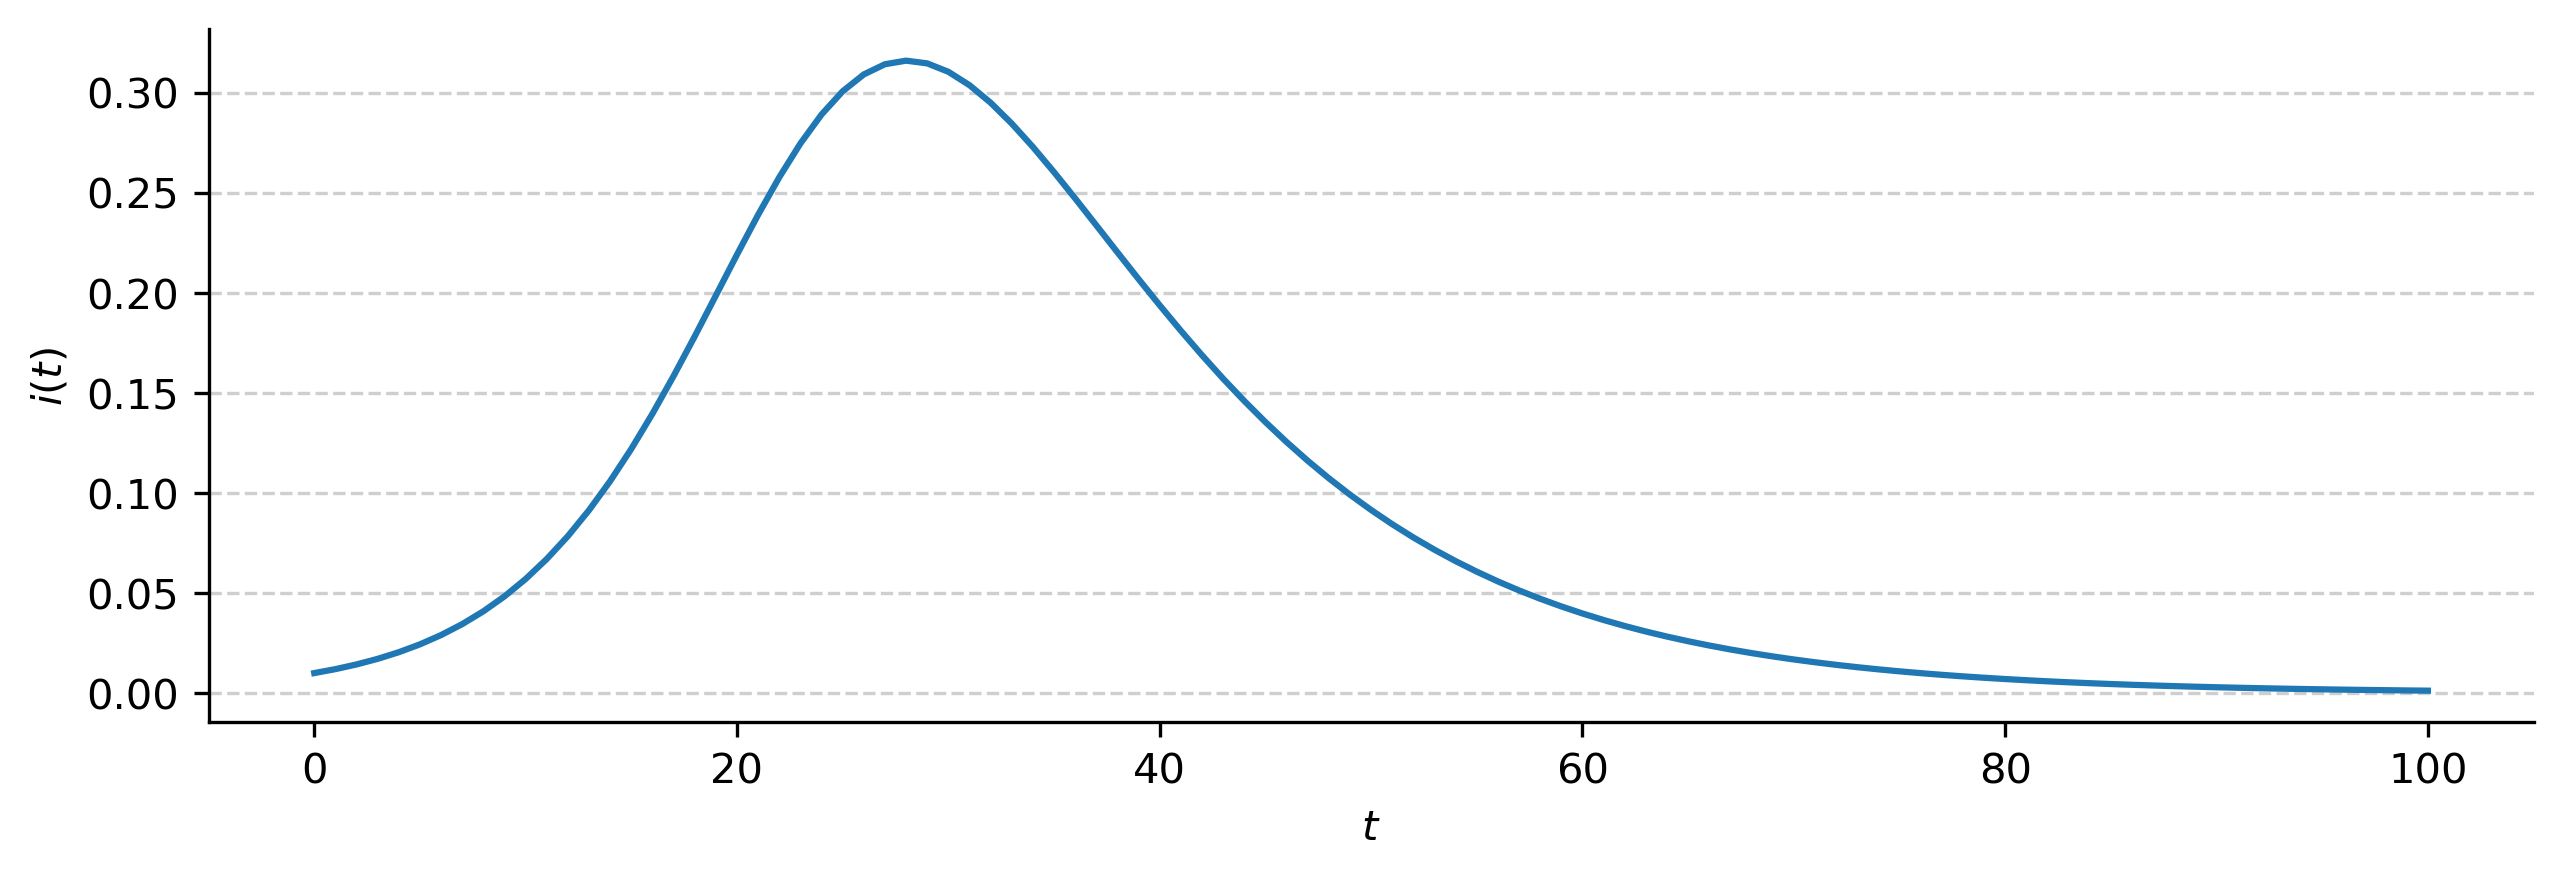

In [6]:
S, I, R, t = SIR_deterministic(0.3, 0.1, dt=1.0, N=10**6)
fig, ax = plt.subplots(dpi=300, figsize=(10,3))
ax.plot(t, I  / 10**6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.6)
ax.set_xlabel("$t$")
ax.set_ylabel("$i(t)$")

## Stochastic SIR

In the following, we provide a function that runs a stochastic simulation of the SIR model:

In [12]:
def SIR_stochastic(beta : float,
                   mu : float, 
                   N : int, 
                   dt : float = 1.0, 
                   I0_frac : float = 0.01, 
                   T : int  = 100):
    """
    This function runs a stochastic simulation of the SIR model
    Parameters
    ----------
    - beta (float): transmission rate
    - mu (float): recovery rate
    - N (int): population size 
    - dt (float, optional): integration step. Default is 1.0.
    - I0_frac (float, optional): initial fraction of infected. Default is 0.01 (1%).
    - T (int, optional): simulation length in steps. Default is 100. 
    
    Returns
    -------
    - evolution of S, I, R compartments
    """
    I0 = np.random.binomial(N, I0_frac)
    S, I, R, t = [N - I0], [I0], [0], [0]
    for i in range(T):
        new_infected = np.random.binomial(S[-1], beta * I[-1] / N * dt)
        new_recovered = np.random.binomial(I[-1], mu * dt)
        S.append(S[-1] - new_infected)
        I.append(I[-1] + new_infected - new_recovered)
        R.append(R[-1] + new_recovered)
        t.append(t[-1] + dt)
    return np.array(S), np.array(I), np.array(R),  np.array(t)

Text(0, 0.5, '$i(t)$')

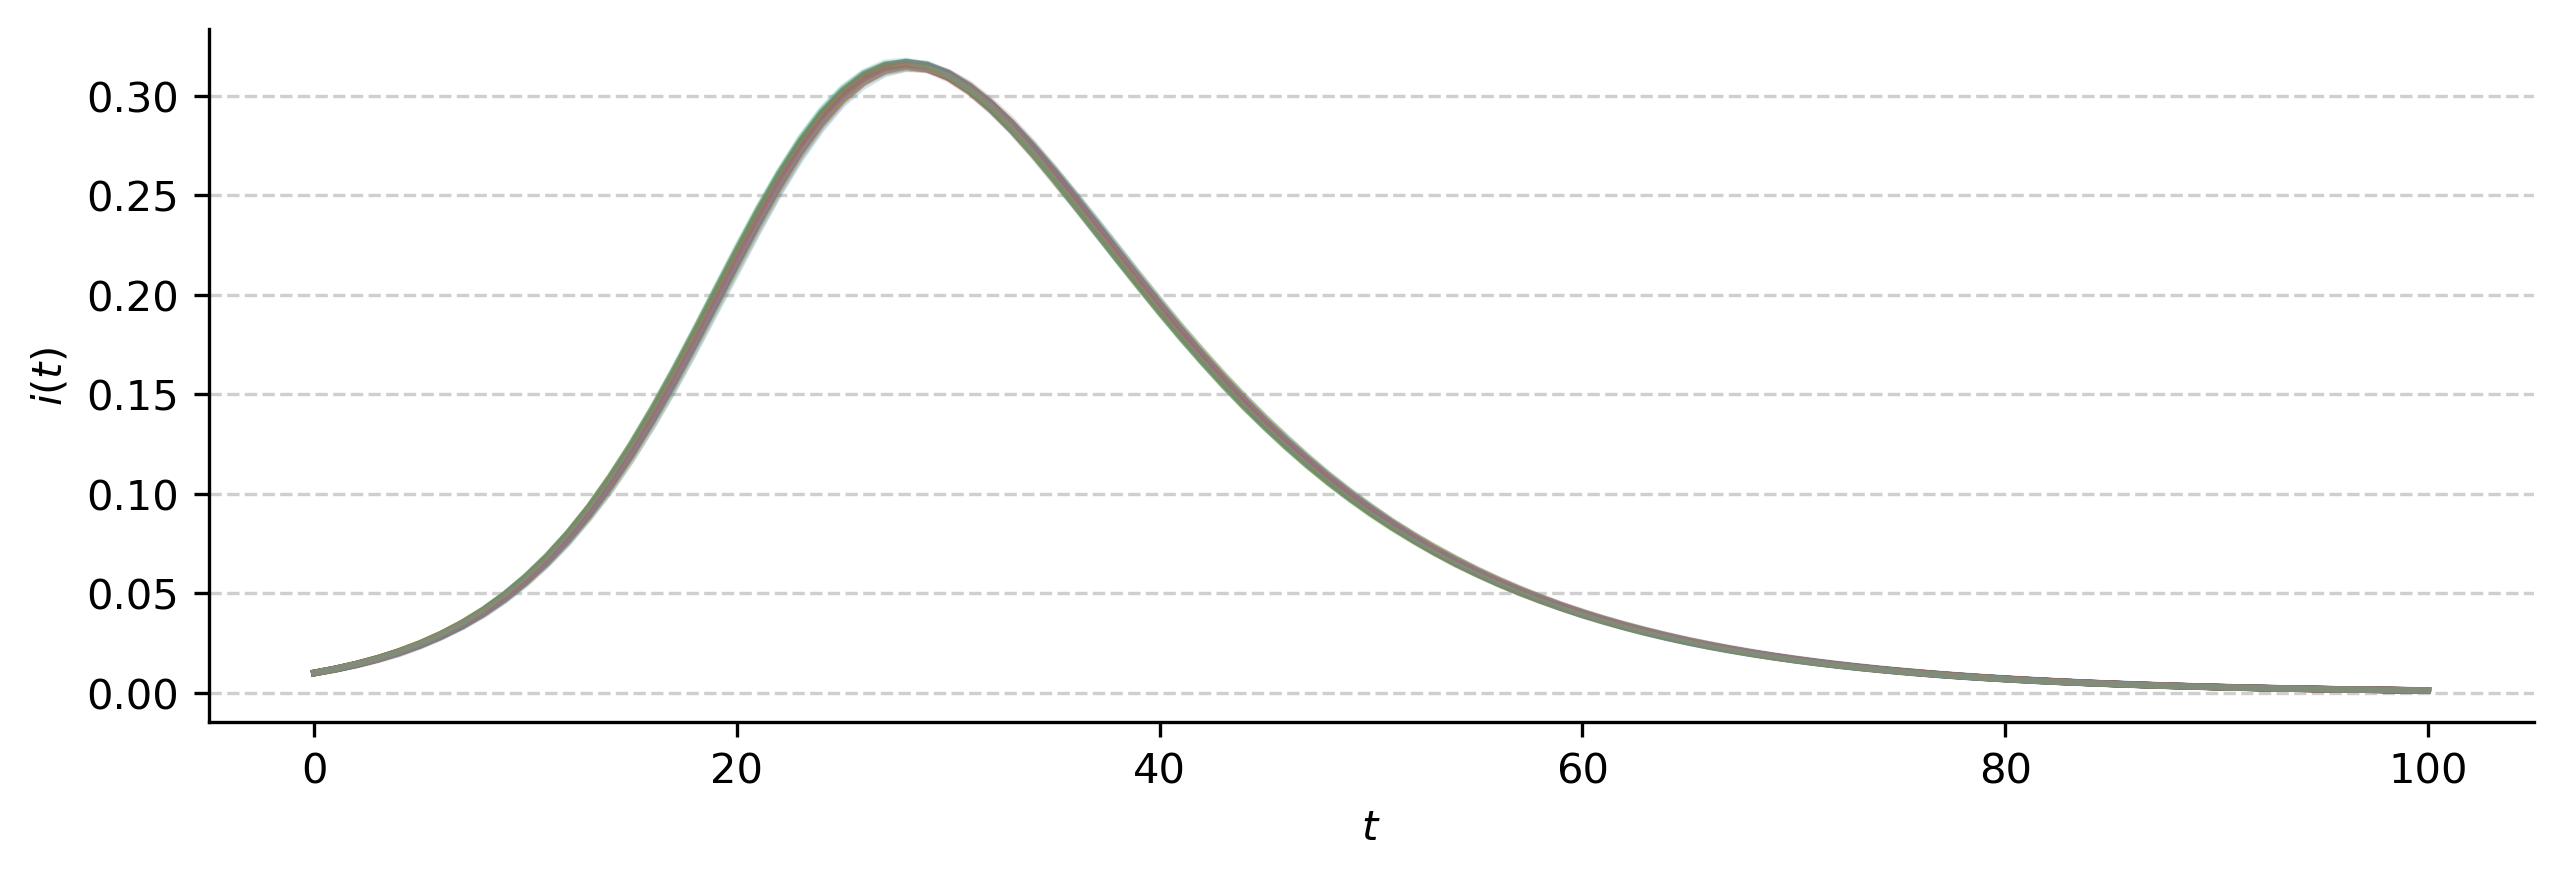

In [14]:
fig, ax = plt.subplots(dpi=300, figsize=(10,3))

for i in range(100):
    S, I, R, t = SIR_stochastic(0.3, 0.1, dt=1.0, N=10**6)
    ax.plot(t, I  / 10**6, alpha=0.2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.6)
ax.set_xlabel("$t$")
ax.set_ylabel("$i(t)$")

Text(0, 0.5, '$i(t)$')

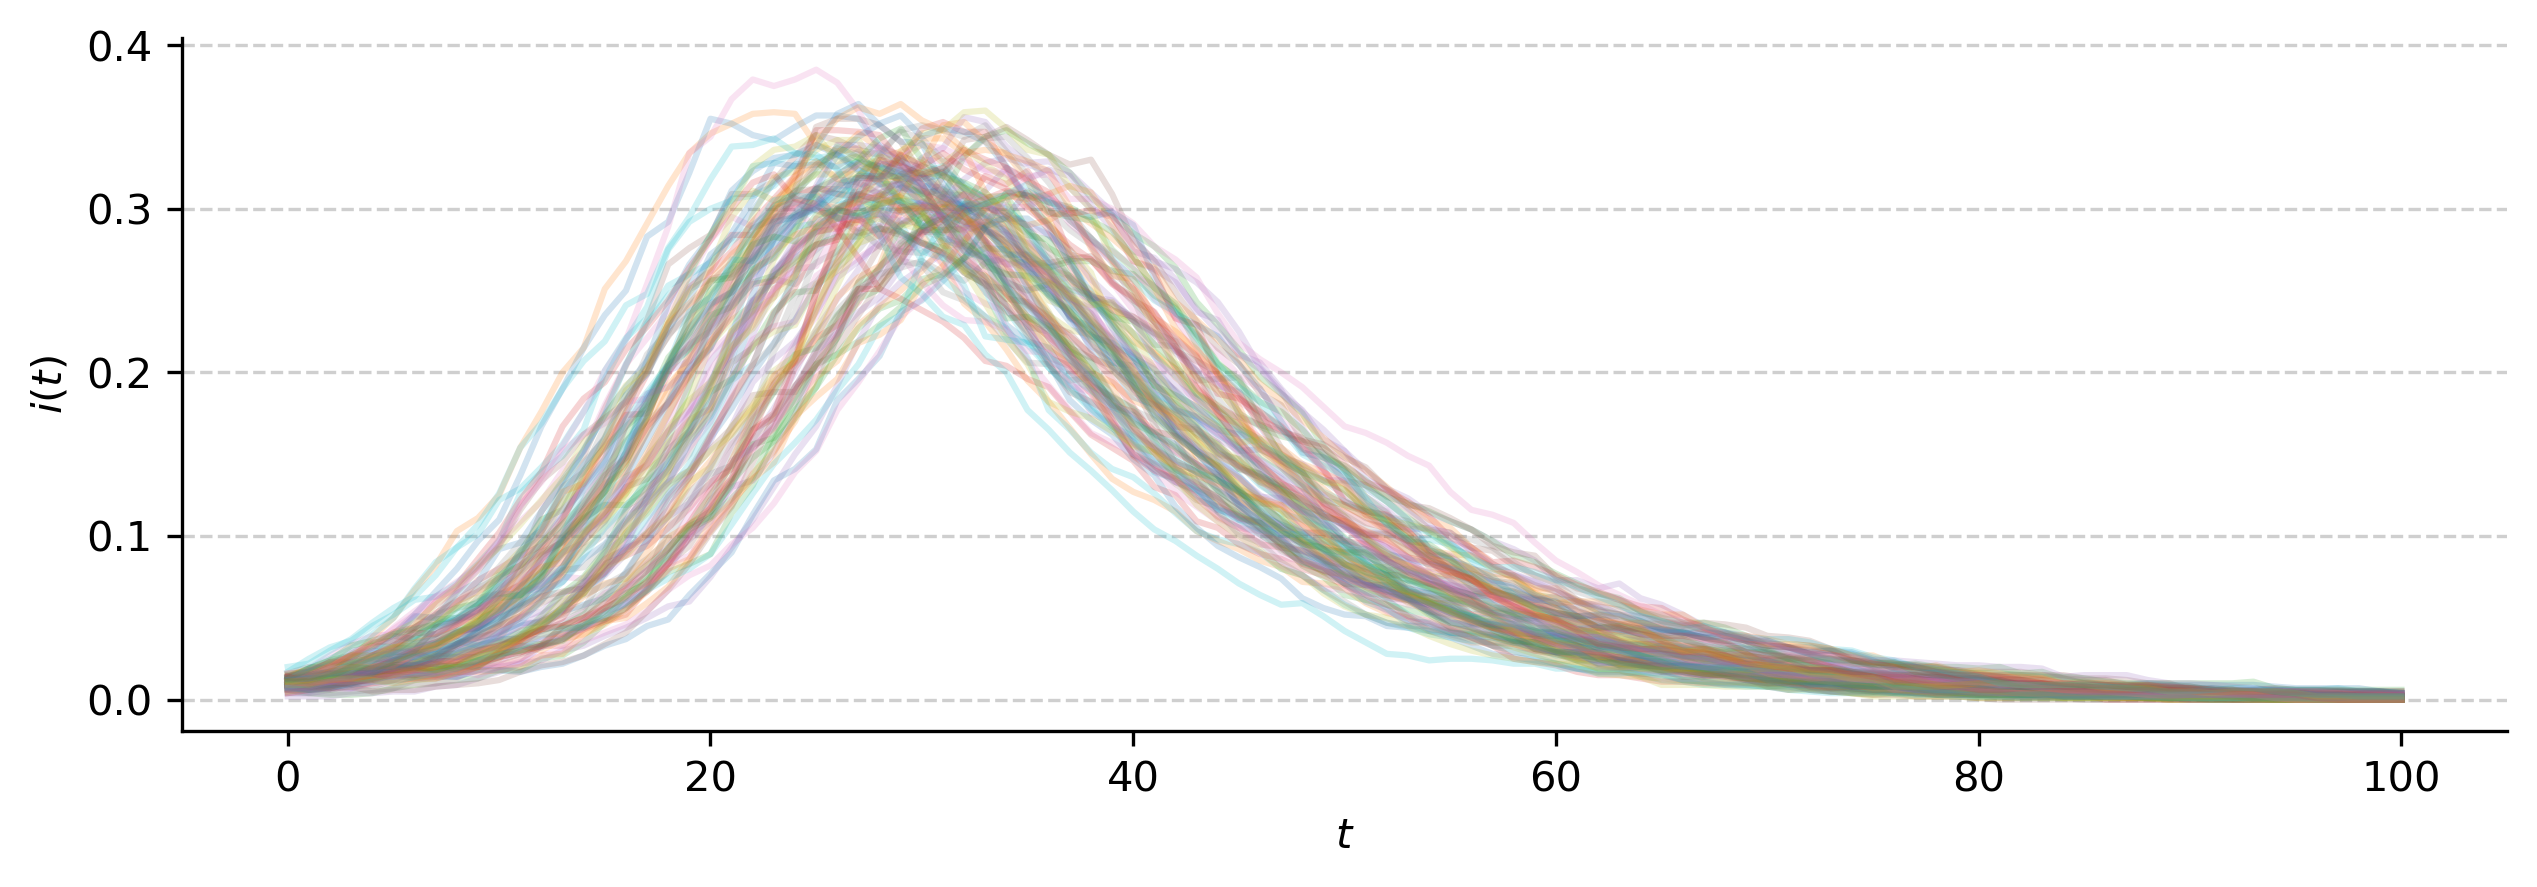

In [16]:
fig, ax = plt.subplots(dpi=300, figsize=(10,3))

for i in range(100):
    S, I, R, t = SIR_stochastic(0.3, 0.1, dt=1.0, N=1000)
    ax.plot(t, I  / 1000, alpha=0.2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.6)
ax.set_xlabel("$t$")
ax.set_ylabel("$i(t)$")

# SIR Model with age structure

In [21]:
def SIR_contacts(C : np.array, 
                 beta : float, 
                 mu : float, 
                 Nk: np.array, 
                 I0_frac : float = 0.01, 
                 T : int = 100):
    """
    This function runs a deterministic SIR model with age structure
    Parameters
    ----------
    - C (np.array): contact matrix
    - beta (float): transmission rate
    - mu (float): recovery rate
    - Nk (np.array): number of individuals in different age groups
    - I0_frac (float, optional): initial fraction of infected. Default is 0.01 (1%).
    - T (int, optional): simulation length in steps. Default is 100. 

    Returns
    -------
    - evolution of S_k, I_k, R_k compartments
    """
    I0 = int(Nk.sum() * I0_frac)
    nage = len(C)
    S, I, R = np.zeros((T, nage)), np.zeros((T, nage)), np.zeros((T, nage))

    # initialize infected proportionally in different age groups 
    for k in range(nage):
        I[0, k] = int(I0 / nage)
        S[0, k] = Nk[k] - I[0, k]

    # simulate
    for i in np.arange(0, T-1, 1):
        S_next, I_next, R_next = S[i].copy(), I[i].copy(), R[i].copy()
        for k in range(nage):
            new_infected_k = beta * np.sum(C[k, :] * I[i, :] / Nk) * S[i, k]
            new_recovered_k = mu * I[i, k]
            S_next[k] = S[i, k] - new_infected_k
            I_next[k] = I[i, k] + new_infected_k - new_recovered_k
            R_next[k] = R[i, k] + new_recovered_k
        S[i+1] = S_next
        I[i+1] = I_next
        R[i+1] = R_next
        
    return np.array(S), np.array(I), np.array(R)

In [24]:
Nk_uk = pd.read_csv("./contact_matrices_152_countries/United Kingdom-2020.csv").Value
Nk_ke = pd.read_csv("./contact_matrices_152_countries/Kenya-2020.csv").Value
ages = pd.read_csv("./contact_matrices_152_countries/United Kingdom-2020.csv").Age.values

contacts_uk = pd.read_excel("./contact_matrices_152_countries/MUestimates_all_locations_2.xlsx", sheet_name="United Kingdom of Great Britain", header=None)
contacts_ke = pd.read_excel("./contact_matrices_152_countries/MUestimates_all_locations_1.xlsx", sheet_name="Kenya")

S_uk, I_uk, R_uk = SIR_contacts(contacts_uk.values, 0.05, 0.1, Nk_uk.values)
S_ke, I_ke, R_ke = SIR_contacts(contacts_ke.values, 0.05, 0.1, Nk_ke.values)

/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


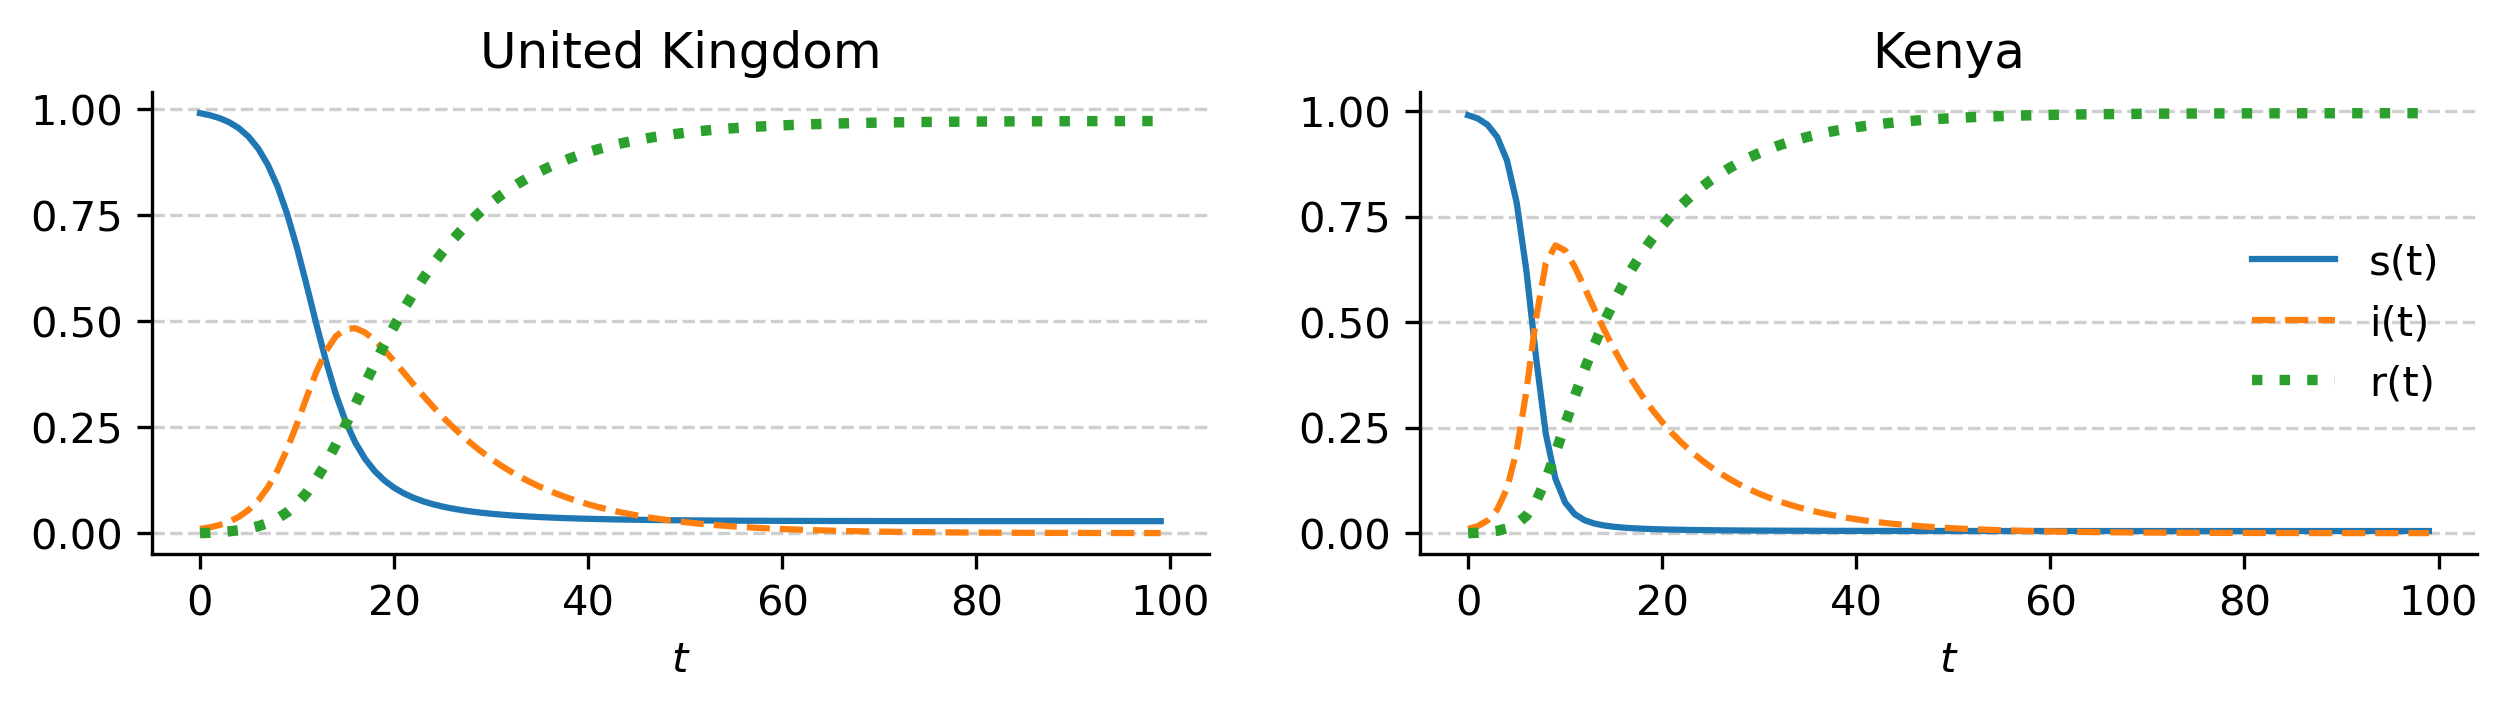

In [25]:
fig, axes = plt.subplots(ncols=2, dpi=300, figsize=(10, 2))

axes[0].plot(np.sum(S_uk, axis=1) / np.sum(Nk_uk), label="s(t)", linestyle="-")
axes[0].plot(np.sum(I_uk, axis=1) / np.sum(Nk_uk), label="i(t)", linestyle="--")
axes[0].plot(np.sum(R_uk, axis=1) / np.sum(Nk_uk), label="r(t)", linestyle="dotted", linewidth=2.5)

axes[1].plot(np.sum(S_ke, axis=1) / np.sum(Nk_ke), label="s(t)", linestyle="-")
axes[1].plot(np.sum(I_ke, axis=1) / np.sum(Nk_ke), label="i(t)", linestyle="--")
axes[1].plot(np.sum(R_ke, axis=1) / np.sum(Nk_ke), label="r(t)", linestyle="dotted", linewidth=2.5)

axes[1].legend(loc=5, frameon=False)
axes[0].set_title("United Kingdom")
axes[1].set_title("Kenya")

for ax in axes:
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.set_xlabel("$t$")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
